# Q-Learning Agent 
---
En este notebook se desarrolla un agente de Q-Learning que aprende a escapar de un pequeño laberinto. Para ello, se diseña un pequeño grid que recrea el puzzle de donde debe escapar, el cual incorpora una meta y un punto de "game over". Adicionalmente, se explora el diseño, testeo y optimización de políticas del agente. Para lograr el objetivo anterior, se definen algunas de las variables del agente de Q-Learning:

**1. Ambiente:** El ambiente corresponde al laberinto en donde se encuentra el agente. Este laberinto consistirá en un grid de tamaño 4x3, el cual incorporá un punto de llegada y un punto de "game over". Adicionalmente, una de las casillas del grid será innacesible (o lo que es lo mismo, tendrá un muro).

**2. Estados:** Los estados del agente corresponderán a la posición (coordenadas) en donde se encuentre. Por ejemplo, el estado del agente en el momento $t$ es $S_{t} = (1, 2)$.

**3. Acciones:** Las acciones que puede tomar el agente son: Arriba ($up$), Abajo ($down$), Derecha ($right$), Izquierda ($left$). En caso en que el agente se "estrelle con un muro", el robot vuelve al estado en donde estaba.

**4. Recompensas:** Para el caso del agente en el laberinto, se incluirá una "penalidad de vida", es decir, cada vez que el agente tome una acción, recibirá una recompensa constante $r$. Si llega a la meta, recibirá una recompensa $R_{win}$ y se pierde $R_{loss}$

<img src="https://miro.medium.com/max/725/1*NyWUkwz1QhrVJj9ygCQ5nA.png" alt="Smiley face" height="300" width="450">

In [146]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random

%matplotlib inline

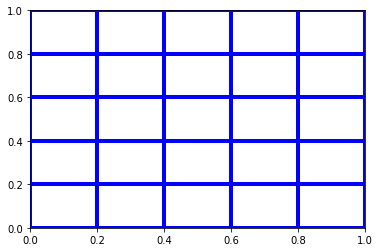

In [58]:

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)

ax.axhline(linewidth=4, color='b')
ax.axhline(1, linewidth=4, color='b')

ax.axvline(linewidth=4, color='b')
ax.axvline(1, linewidth=4, color='b')

ax.axhline(0.2, linewidth=4, color='b')
ax.axhline(0.4, linewidth=4, color='b')
ax.axhline(0.6, linewidth=4, color='b')
ax.axhline(0.8, linewidth=4, color='b')

ax.axvline(0.2, linewidth=4, color='b')
ax.axvline(0.4, linewidth=4, color='b')
ax.axvline(0.6, linewidth=4, color='b')
ax.axvline(0.8, linewidth=4, color='b')

patches.Rectangle((0.2, 0.4), width = 0.2, height = 0.2, angle=0.0, fill = True, visible = True, facecolor = "black")

In [51]:
patches.Rectangle((0.2, 0.4), width = 0.2, height = 0.2, angle=0.0, fill = True, visible = True, facecolor = "black").plot()

AttributeError: 'Rectangle' object has no attribute 'plot'

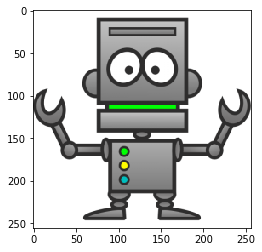

In [116]:
from PIL import Image
import numpy as np
im = np.array(Image.open('./Robot.png'), dtype=np.uint8)
plt.imshow(im)

In [152]:
def draw_grid(x, y):

    #plt.clf()
    blue = "#2D2D33"

    fig1 = plt.figure(figsize=(4, 4))
    ax1 = fig1.add_subplot(111, aspect='equal')

    ax1.axhline(linewidth=2, color=blue)
    ax1.axhline(1, linewidth=2, color=blue)

    ax1.axvline(linewidth=2, color=blue)
    ax1.axvline(1, linewidth=2, color=blue)

    ax1.axhline(0.2, linewidth=2, color=blue)
    ax1.axhline(0.4, linewidth=2, color=blue)
    ax1.axhline(0.6, linewidth=2, color=blue)
    ax1.axhline(0.8, linewidth=2, color=blue)

    ax1.axvline(0.2, linewidth=2, color=blue)
    ax1.axvline(0.4, linewidth=2, color=blue)
    ax1.axvline(0.6, linewidth=2, color=blue)
    ax1.axvline(0.8, linewidth=2, color=blue)

    # SALIDA, META Y GAME OVER
    ax1.add_patch(
        patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924")
    )


    ax1.add_patch(
        patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#68FF33")
    )

    ax1.add_patch(
        patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#FF5533")
    )


    # MUROS

     # "#33A4FF"

    ax1.add_patch(
        patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF")
    )

    ax1.add_patch(
        patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF")
    )

    ax1.add_patch(
        patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF")
    )

    ax1.add_patch(
        patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#33A4FF")
    )

    ax1.add_patch(
        patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF")
    )

    plt.ylim((0, 1))
    plt.xlim((0, 1))

    pos_correct = -.02

    plt.text(0.9 + pos_correct, 0.9 + pos_correct, "1", fontsize=16)
    plt.text(0.9 + pos_correct, 0.7 + pos_correct, "-1", fontsize=16)

    plt.scatter(x, y, s = 100, color = "black", marker = "x", edgecolors = "black", zorder = 10)

    #plt.set_size_inches(18.5, 10.5)
    plt.axis("off")

    #plt.clf()
    plt.show()

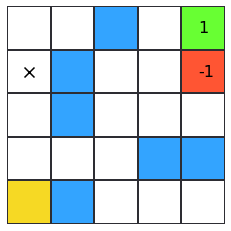

In [156]:
pos = [0.1, 0.3, 0.5, 0.7, 0.9]
for i in range(0, 1):
    draw_grid(pos[random.randint(1, 100) % len(pos)], pos[random.randint(1, 100) % len(pos)])
    time.sleep(1)

In [159]:
class GridWorld():
    
    def __init__(width = 5, height = 5, living_penalty = 0):
        self.width = width, 
        self.height = height,
        self.living_penalty = living_penalty
        
        # State value matrix.
        state_matrix = list()
        for i in range(0, height):
            row_values = list()
    
            for j in range(0, width):
                row_values.append(self.living_penalty)
            state_matrix.append(row_values)
        
        # Action State value matrix.
        action_state_matrix = list()
        for i in range(0, height):
            row_values = list()
            for j in range(0, width):
                state_q_values = list()
                
                for k in range(0, 4):
                    state_q_values.append(0)
                    
                row_values.append(state_q_values)
            action_state_matrix.append(row_values)
                    
    def stateValue():
        return ""
    
    def actionStateValue():
        return ""
        
        
        
        
class GridGraphics():
    
    def __init__():
        return ""